# Analysis of Botswana MapBox Mobility Data

The purpose of this notebook is to visualize and assess the MapBox mobility data over Botswana for School and Non-School samples.

MapBox Docs: https://docs.mapbox.com/data/movement/guides

## Imports and Setup

In [112]:
import os
import requests
from io import StringIO
import pandas as pd
import folium
from shapely.geometry import Point
import geopandas as gpd
from functools import partial
import pyproj
from shapely import geometry
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import transform
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import mercantile
from itertools import combinations
from sklearn.cluster import DBSCAN, KMeans

## Loading Data

In [113]:
# Loading hourly mobility data
hourly_movement_df = pd.read_csv('/Users/kelseydoerksen/Desktop/Giga/BWA/Mobility/weekday-weekend-1hour.csv')

# Loading 4-hour mobility day
day_of_week_4hour_df = pd.read_csv('/Users/kelseydoerksen/Desktop/Giga/BWA/Mobility/day_of_week-4hour.csv')

# Loading BWA school geojson data
school_df = gpd.read_file('/Users/kelseydoerksen/Desktop/Giga/SchoolMapping/BWA/BWA_train.geojson')

## Data Processing
We would like to aggregate and analyze the activity associated with individual school and non-school samples.

1. Define 300m boundary for each school/non-school sample
2. Get a list of MapBox quadkey tiles that overlap school/non-school buffer zone
3. Take summary statistics of MapBox movement data


### Adding Mobility Information

In [114]:
# Generate circular boundary around school at 300m radius
def aeqd_reproj_buffer(center, radius=300):
    """
    Converts center coordinates to AEQD projection,
    draws a circle of given radius around the center coordinates,
    converts both polygons back to original ESRI:54009
    
    Args:
        center center coordinates of the circle (derived from school location)
        radius (integer): circle's radius in meters.
    
    Returns:
        A shapely.geometry Polygon object for circle of given radius.
    """
    lat = center.y
    lon = center.x
    
    esri54009_to_epsg4326 = Transformer.from_crs("ESRI:54009", "EPSG:4326", always_xy=True)
    epsg4326_to_aeqd = Transformer.from_crs("EPSG:4326", "ESRI:54032")
    aeqd_to_epsg4326 = Transformer.from_crs("ESRI:54032", "EPSG:4326", always_xy=False)

    # Transform the center coordinates from 54009 to AEQD
    point_epsg4326 = Point(esri54009_to_epsg4326.transform(lon, lat))
    point_transformed = Point(epsg4326_to_aeqd.transform(point_epsg4326.x, point_epsg4326.y))
    
    # Get buffer of defined radius
    buffer = point_transformed.buffer(radius)
    
    # Get the polygon with lat lon coordinates
    circle_poly = transform(aeqd_to_epsg4326.transform, buffer)
    #.exterior.coords[:]
    
    return circle_poly

In [115]:
# Get circle buffer and add to school_df
school_df['aeqd_reproj_circle'] = school_df['geometry'].apply(aeqd_reproj_buffer)

In [116]:
# Get a list of the mapbox data that is overlapping the radius extent we specified
def generate_quadkeys(circle_poly, zoom):
    """
    Generate a list of quadkeys that overlap our circles
    Args:
        circle_poly (shapely.geometry Polygon): circle polygon object drawn 
            around a school/non-school
        zoom (integer): zoom level.
        
    Return:
        List of quadkeys as string
    """
    return [mercantile.quadkey(x) for x in mercantile.tiles(*circle_poly.bounds, zoom)]

In [117]:
# Add zoom level 18 quadkeys to school dataset
school_df['z18_quadkeys'] = school_df.apply(lambda x: generate_quadkeys(x['aeqd_reproj_circle'], 18),axis=1)

In [118]:
def add_movement_data(df, movement_df, month_subset):
    """
    Add movement data if MapBox quadkey exists
    Args:
        df: school/non-school df
        movement_df: MapBox mobility data df
        timeperiod: month of movement data to query 
        
    Return:
        df with movement data
    """
    movement_dict = {
        'oct': '2023-10-01',
        'nov': '2023-11-01',
        'dec': '2023-12-01'
    }
    
    # Subset movement dict to the time we are interested in
    if not month_subset == 'all':
        movement_df = movement_df[movement_df["start_date"] == movement_dict['{}'.format(month_subset)]]
    
    full_data = []
    for i in range(len(df)):
        data_list = []
        for z18_quadkey in df.loc[i]["z18_quadkeys"]:
            data_list.append(movement_df[movement_df["geography"] == int(z18_quadkey)])
        data_df = pd.concat(data_list)
        data_df['UID'] = df.loc[i]['UID']
        data_df['name'] = df.loc[i]['name']
        full_data.append(data_df)
        
    full_df = pd.concat(full_data)
    return full_df

In [264]:
def calc_hourly_average_ai(df, time_period):
    """
    Aggregate movement data to hourly sum based on 
    quadkeys that interset with user-defined buffer
    and calculate the hourly average ai over 
    the time period for all of the samples
    time_period == 0: weekday
    time_period == 1: weekend
    """
    grouped = df.groupby(['UID', 'agg_day_period', 'agg_time_period', 'start_date', 'end_date'])
    sum_data = grouped.activity_index_total.sum()
    sum_df = sum_data.reset_index()
    
    hourly_df = sum_df[sum_df['agg_day_period'] == int(time_period)]
    mean_hourly_data = hourly_df.groupby(['agg_time_period']).mean(numeric_only=True)['activity_index_total']
    
    return mean_hourly_data

In [239]:
def max_min_normalize(df):
    """
    max-min normalizing to compare
    data distributions
    """
    normalized_df = (df-df.min())/(df.max()-df.min())
    return normalized_df

### Clustering based on Location
Using K-Means clustering to cluster data together. From MapBox: The data for each country is normalized within that coutntry. Comparisons made over short timescales and short distances are more trustworthy than those made over long timescales and distances. Comparisons made over areas that have a high average activity are more trustworthy than those made over areas that have low average activity.

In [121]:
def add_cluster_id(df, n_clusters):
    """
    Add cluster id to dataframe
    """
    # From plot, we saw 4 is the optimal cluster number
    kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 5,  max_iter=400, n_init=10)
    y_kmeans = kmeans.fit_predict(coords)
    k=pd.DataFrame(y_kmeans, columns=['cluster'])
    
    # add cluster class to school dataframe
    df_with_cluster = school_df.join(k)
    
    return df_with_cluster

In [122]:
# Get school data as coords
coords = []
for i in range(len(school_df)):
    coords.append([school_df.loc[i].geometry.x, school_df.loc[i].geometry.y])

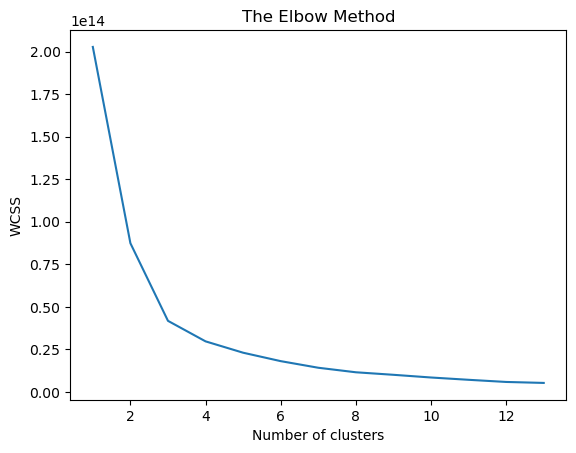

In [123]:
# Using elbow method to determine number of clusters we should use
wcss = []
for i in range(1, 14):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init=10)
    kmeans.fit(coords)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 14), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [124]:
# Add cluster id to dataframe
school_df = add_cluster_id(school_df, 4)

Text(0.5, 1.0, 'K-Means Clustered school and non-school samples')

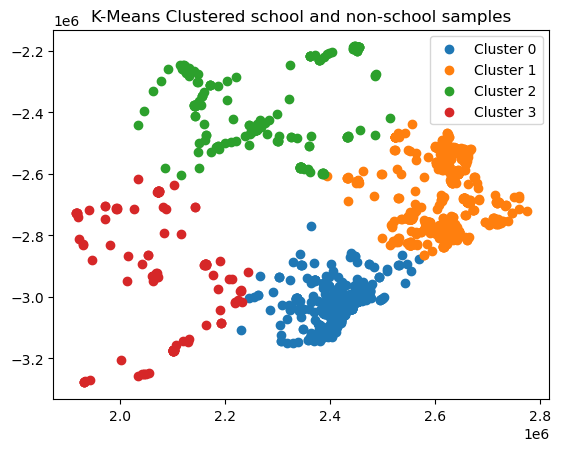

In [314]:
filtered_label0 = school_df[school_df['cluster'] == 0]
filtered_label1 = school_df[school_df['cluster'] == 1]
filtered_label2 = school_df[school_df['cluster'] == 2]
filtered_label3 = school_df[school_df['cluster'] == 3]

plt.scatter(filtered_label0.geometry.x, filtered_label0.geometry.y, label='Cluster 0')
plt.scatter(filtered_label1.geometry.x, filtered_label1.geometry.y, label='Cluster 1')
plt.scatter(filtered_label2.geometry.x, filtered_label2.geometry.y, label='Cluster 2')
plt.scatter(filtered_label3.geometry.x, filtered_label3.geometry.y, label='Cluster 3')
plt.legend()
plt.title('K-Means Clustered school and non-school samples')

### School and Non-School Sample Selection
For initial demo, 3 schools and non-schools are selected randomly via QGIS manual inspection in rural and urban areas based on the definition in the BWA_train.gejson file. 

Non-Schools are selected by finding a close non-school point to a school point.

The definitions of each type of non-school are from their UID is:

Urban:
- OSM-BWA-NON_SCHOOL-00000835: Cloud Networks Business Center
- OSM-BWA-NON_SCHOOL-00000849: Mmopane Police
- OVERTURE-BWA-NON_SCHOOL-00000420: Mbizi Guest House Sebina

Rural: 
- OSM-BWA-NON_SCHOOL-00000813: Bokspits Clinic
- OSM-BWA-NON_SCHOOL-00000561: Sanitary Checkpoint
- OSM-BWA-NON_SCHOOL-00000027: Game Scouts - Park Entry


In [ ]:
# Uncomment if you would like to only run on a small subset of the schools

# Subsetting data into rural-school, rural-nonschool, urban-school, urban-nonschool
# Samples selected based on visiual inspection in QGIS 
'''
urban_schools_subset = ['OSM-BWA-SCHOOL-00000103', 'OSM-BWA-SCHOOL-00000152', 'UNICEF-BWA-SCHOOL-00000048']
rural_schools_subset = ['UNICEF-BWA-SCHOOL-00000335', 'UNICEF-BWA-SCHOOL-00000683', 'UNICEF-BWA-SCHOOL-00000096']
urban_non_schools_subset = ['OSM-BWA-NON_SCHOOL-00000835', 'OSM-BWA-NON_SCHOOL-00000849', 'OVERTURE-BWA-NON_SCHOOL-00000420']
rural_non_schools_subset = ['OSM-BWA-NON_SCHOOL-00000813', 'OSM-BWA-NON_SCHOOL-00000561', 'OSM-BWA-NON_SCHOOL-00000027']

rural_school_df = school_df.copy(deep=True)[school_df['UID'].isin(rural_schools)]
urban_school_df = school_df.copy(deep=True)[school_df['UID'].isin(urban_schools)]
rural_nonschool_df = school_df.copy(deep=True)[school_df['UID'].isin(rural_non_schools)]
urban_nonschool_df = school_df.copy(deep=True)[school_df['UID'].isin(urban_non_schools)]
'''

In [129]:
# Subset into school and nonschool
school_samples_df = school_df.copy(deep=True)[school_df['class'] == 'school']
nonschool_samples_df = school_df.copy(deep=True)[school_df['class'] == 'non_school']

### Subset Non-Schools based on building type
We know that our ML models struggle with False Positives on samples represented by hospitals & clinics, police stations and farmsteads. In theory, the activity level around these types of buildings vs schools should be different, so we would like to subset the samples by these categories to observe

In [130]:
# Dropping nans from samples because we can't associate them with building type if not defined
school_df_no_nan = nonschools_samples_df.dropna(subset=['name'])

In [131]:
# Defining building types for non-schools (to update to not have to make case sensitive)
clinics = ['clinic', 'hospital', 'health', 'medical', 'Clinic', 'Hospital', 'Health', 'Medical']
police = ['police', 'Police']
farm = ['farm', 'Farm']

In [132]:
def filter_df(df, filter_list):
    """
    Filter df based on filtering list criteria
    """
    df_list = []
    for criteria in filter_list:
        filt_df = df[df['name'].str.contains(criteria)]
        filt_df = filt_df.rename(columns={"geometry": "geo"})
        df_list.append(filt_df)
    
    combined_df = pd.concat(df_list, axis=0, ignore_index=True)
    return combined_df

In [133]:
clinic_df = filter_df(school_df_no_nan, clinics)
police_df = filter_df(school_df_no_nan, police)
farm_df = filter_df(school_df_no_nan, farm)

## Data Analysis - Non-School Mobility
Some quick plotting to look at non-school categories that our model has diffifculty deciphering from school

### Clinics

In [159]:
clinic_df = clinic_df.reset_index().drop(columns=['index'])
clinic_df_with_movement = add_movement_data(clinic_df, hourly_movement_df, 'nov')
clinic_df_sum_hourly_weekday = calc_hourly_average_ai(clinic_df_sum_movement,0)
clinic_df_sum_hourly_weekend = calc_hourly_average_ai(clinic_df_sum_movement,1)

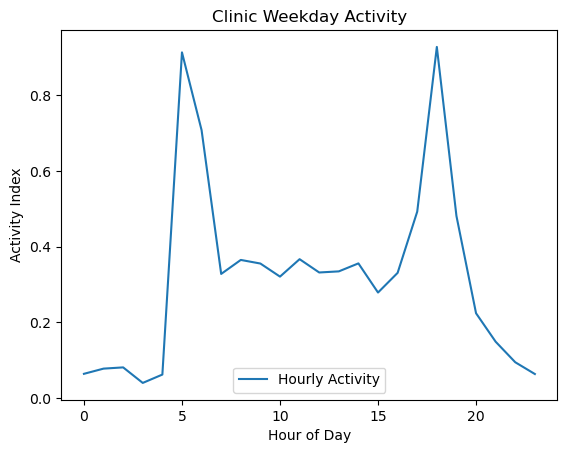

In [160]:
# Plotting
plt.plot(clinic_df_sum_hourly_weekday, label='Hourly Activity')
plt.xlabel('Hour of Day')
plt.ylabel('Activity Index')
plt.legend()
plt.title('Clinic Weekday Activity')
plt.show()

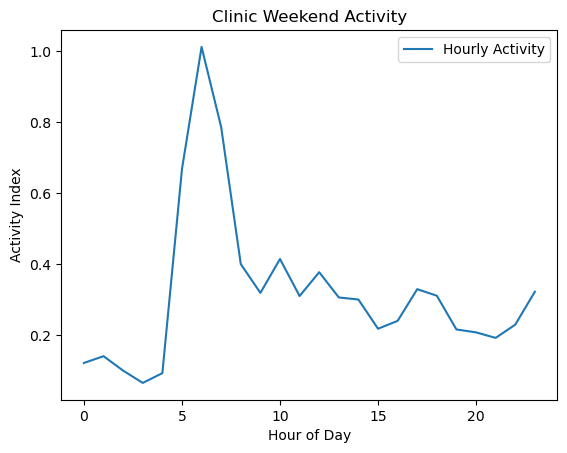

In [161]:
# Plotting
plt.plot(clinic_df_sum_hourly_weekend, label='Hourly Activity')
plt.xlabel('Hour of Day')
plt.ylabel('Activity Index')
plt.legend()
plt.title('Clinic Weekend Activity')
plt.show()

### Police Stations

In [157]:
police_df = police_df.reset_index().drop(columns=['index'])
police_df_with_movement = add_movement_data(police_df, hourly_movement_df, 'nov')
police_df_sum_hourly_weekday = calc_hourly_average_ai(police_df_sum_movement,0)
police_df_sum_hourly_weekend = calc_hourly_average_ai(police_df_sum_movement,1)

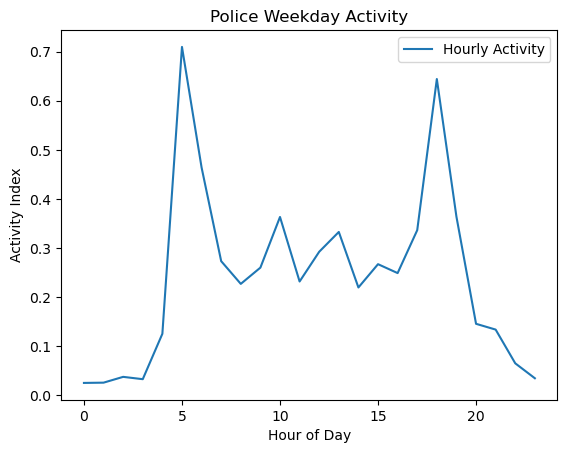

In [155]:
# Plotting
plt.plot(police_df_sum_hourly_weekday, label='Hourly Activity')
plt.xlabel('Hour of Day')
plt.ylabel('Activity Index')
plt.legend()
plt.title('Police Weekday Activity')
plt.show()

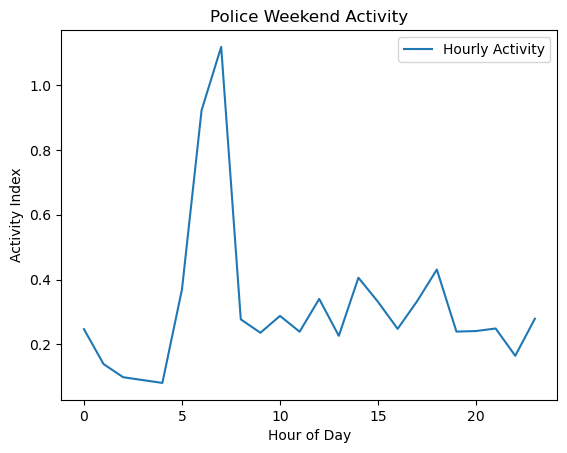

In [158]:
# Plotting
plt.plot(police_df_sum_hourly_weekend, label='Hourly Activity')
plt.xlabel('Hour of Day')
plt.ylabel('Activity Index')
plt.legend()
plt.title('Police Weekend Activity')
plt.show()

### Farms

In [163]:
farm_df = farm_df.reset_index().drop(columns=['index'])
farm_df_with_movement = add_movement_data(farm_df, hourly_movement_df, 'nov')
farm_df_sum_hourly_weekday = calc_hourly_average_ai(farm_df_sum_movement,0)
farm_df_sum_hourly_weekend = calc_hourly_average_ai(farm_df_sum_movement,1)

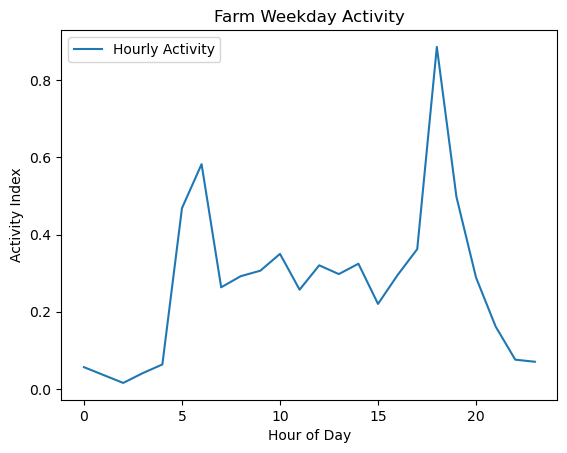

In [164]:
# Plotting
plt.plot(farm_df_sum_hourly_weekday, label='Hourly Activity')
plt.xlabel('Hour of Day')
plt.ylabel('Activity Index')
plt.legend()
plt.title('Farm Weekday Activity')
plt.show()

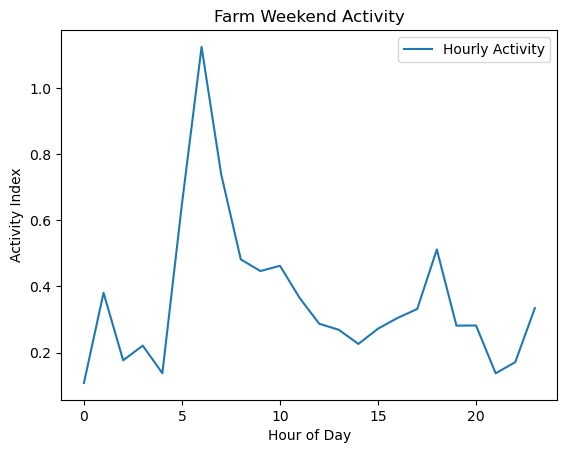

In [165]:
# Plotting
plt.plot(farm_df_sum_hourly_weekend, label='Hourly Activity')
plt.xlabel('Hour of Day')
plt.ylabel('Activity Index')
plt.legend()
plt.title('Farm Weekend Activity')
plt.show()

## Clustered Data Analysis

In [ ]:
def cluster_comparison(df_dict, sample_type, month, time_period):
    """
    Run cluster comparison 
    :param: df_dict: dictionary of dataframes for a cluster
    :param: sample_type: school/nonschool
    :param: month: oct, nov, dec, all
    :param: time_period: 0: weekday, 1: weekend
    
    outputs a comparison plot
    """
    
    if time_period == 0:
        time_period_str = 'Weekday'
    if time_period == 1:
        time_period_str = 'Weekend'
    
    # Add movement data
    cluster_1_with_movement = add_movement_data(df_dict[sample_type]['cluster_0'], hourly_movement_df, month)
    cluster_2_with_movement = add_movement_data(df_dict[sample_type]['cluster_1'], hourly_movement_df, month)
    cluster_3_with_movement = add_movement_data(df_dict[sample_type]['cluster_2'], hourly_movement_df, month)
    cluster_4_with_movement = add_movement_data(df_dict[sample_type]['cluster_3'], hourly_movement_df, month)
    
    # Calculate average hourly
    cluster_1_hourly = calc_hourly_average_ai(cluster_1_with_movement, time_period)
    cluster_2_hourly = calc_hourly_average_ai(cluster_2_with_movement, time_period)
    cluster_3_hourly = calc_hourly_average_ai(cluster_3_with_movement, time_period)
    cluster_4_hourly = calc_hourly_average_ai(cluster_4_with_movement, time_period)
    
    # Normalize
    normalize_1 = max_min_normalize(cluster_1_hourly)
    normalize_2 = max_min_normalize(cluster_2_hourly)
    normalize_3 = max_min_normalize(cluster_3_hourly)
    normalize_4 = max_min_normalize(cluster_4_hourly)
    
    # Plotting
    plt.figure(figsize=(24,10))
    plt.plot(normalize_1, label='Cluster 1 Hourly Activity')
    plt.plot(normalize_2, label='Cluster 2 Hourly Activity')
    plt.plot(normalize_3, label='Cluster 3 Hourly Activity')
    plt.plot(normalize_4, label='Cluster 4 Hourly Activity')
    plt.xlabel('Hour of Day')
    plt.ylabel('Activity Index')
    plt.legend()
    plt.title('{} {} Activity'.format(sample_type, time_period_str)
    plt.show()
    

In [290]:
# Subsetting based on clusters
data_dict = {
    'school': {'cluster_0': None, 'cluster_1': None, 'cluster_2': None, 'cluster_3': None,},
    'nonschool': {'cluster_0': None, 'cluster_1': None, 'cluster_2': None, 'cluster_3': None,}
}

for i in range(0, 4):
    data_dict['school']['cluster_{}'.format(i)] = school_samples_df[school_samples_df['cluster'] == i].reset_index().drop(columns=['index'])
    data_dict['nonschool']['cluster_{}'.format(i)] = nonschool_samples_df[nonschool_samples_df['cluster'] == i].reset_index().drop(columns=['index'])

# School weekday in November
cluster_comparison(data_dict, 'school', 'nov', 0)

In [323]:
def generate_cluster_dict(cluster_num, school_df, nonschool_df):
    """
    Creates a dictionary of relevant dfs per cluster
    :param: cluster_num: cluster id number
    :param: school_df: df of school samples
    :param: nonschool_df: df of nonschool samples
    
    :return: dictionary of dataframes for the cluster
    """
    cluster_dict = {}
    cluster_dict['schools'] = school_df[school_df['cluster'] == cluster_num].reset_index().drop(columns=['index'])
    cluster_dict['nonschools'] = nonschool_df[nonschool_df['cluster'] == cluster_num].reset_index().drop(columns=['index'])
    
    # Defining building types for non-schools (to update to not have to make case sensitive)
    clinics = ['clinic', 'hospital', 'health', 'medical', 'Clinic', 'Hospital', 'Health', 'Medical']
    police = ['police', 'Police']
    farm = ['farm', 'Farm']
    
    # Dropping samples with no names for nonschools as we can't identify these by category
    nonschools_no_nan = nonschool_df.dropna(subset=['name'])
    
    # Adding filtered non-schools for cluster to dictionary
    cluster_dict['clinics'] = filter_df(nonschools_no_nan, clinics)
    cluster_dict['police'] = filter_df(nonschools_no_nan, police)
    cluster_dict['farms'] = filter_df(nonschools_no_nan, farm)
    
    # Subset for urban and rural schools
    cluster_dict['urban_schools'] = school_df[school_df['rurban'] == 'urban'].reset_index().drop(columns=['index'])
    cluster_dict['rural_schools'] = school_df[school_df['rurban'] == 'rural'].reset_index().drop(columns=['index'])
    
    # Subset for urban and rural nonschools
    cluster_dict['urban_nonschools'] = nonschool_df[nonschool_df['rurban'] == 'urban'].reset_index().drop(columns=['index'])
    cluster_dict['rural_nonschools'] = nonschool_df[nonschool_df['rurban'] == 'rural'].reset_index().drop(columns=['index'])
    
    return cluster_dict

In [324]:
# Defining cluster dictionaries to compare
cluster_0 = generate_cluster_dict(0, school_samples_df, nonschool_samples_df)
cluster_1 = generate_cluster_dict(1, school_samples_df, nonschool_samples_df)
cluster_2 = generate_cluster_dict(2, school_samples_df, nonschool_samples_df)
cluster_3 = generate_cluster_dict(3, school_samples_df, nonschool_samples_df)

In [363]:
# Write data here to loop through dataframes per cluster and add movement data, then normalize
def generate_hourly_movement_per_cluster(cluster_dict, cluster_id):
    """
    Generate a dictionary for cluster specified of 
    normalized hourly movement data
    :param: cluster_dict: dictionary of dataframes per cluster
    :param: cluster_id: cluster id
    :return: dictionary of hourly weekday and weekend mobility data
    """
    mobility_cluster_dict = {'oct': None, 'nov': None, 'dec': None, 'all': None}
    prefix = 'cluster_{}'.format(cluster_id)
    dates = ['oct', 'nov', 'dec', 'all']
    for date in dates:
        date_dict = {}
        for key in cluster_dict.keys():
            df = cluster_dict[key]
            df_with_movement = add_movement_data(df, hourly_movement_df, date)
            movement_hourly_weekday = calc_hourly_average_ai(df_with_movement, 0)
            movement_hourly_weekend = calc_hourly_average_ai(df_with_movement, 1)
            
            # normalize so we can cross-compare regions
            movement_hourly_weekday_norm = max_min_normalize(movement_hourly_weekday)
            movement_hourly_weekend_norm = max_min_normalize(movement_hourly_weekend)
            
            date_dict['{}_{}_hourly_weekday_ai'.format(prefix, key)] = movement_hourly_weekday_norm
            date_dict['{}_{}_hourly_weekend_ai'.format(prefix, key)] = movement_hourly_weekend_norm
        mobility_cluster_dict[date] = date_dict
    
    return mobility_cluster_dict

In [364]:
# Generate mobility clusters
cluster_0_mobility = generate_hourly_movement_per_cluster(cluster_0, 0)
#cluster_1_mobility = generate_hourly_movement_per_cluster(cluster_1, 1)
#cluster_2_mobility = generate_hourly_movement_per_cluster(cluster_2, 2)
#cluster_3_mobility = generate_hourly_movement_per_cluster(cluster_3, 3)

## Plotting
Hard-coding for cluster 0, november, can be updated based on what cluster you want to analyze

In [369]:
cluster_id = 0

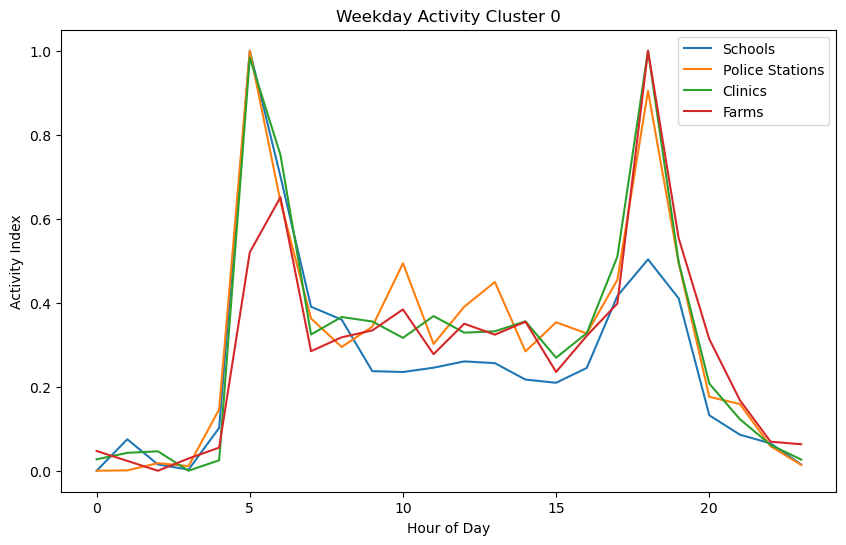

In [370]:
# Plotting weekday schools, police, clinics and farms
plt. figure(figsize=(10, 6)) 
plt.plot(cluster_0_mobility['nov']['cluster_0_schools_hourly_weekday_ai'], label='Schools')
plt.plot(cluster_0_mobility['nov']['cluster_0_police_hourly_weekday_ai'], label='Police Stations')
plt.plot(cluster_0_mobility['nov']['cluster_0_clinics_hourly_weekday_ai'], label='Clinics')
plt.plot(cluster_0_mobility['nov']['cluster_0_farms_hourly_weekday_ai'], label='Farms')
plt.plot
plt.xlabel('Hour of Day')
plt.ylabel('Activity Index')
plt.legend()
plt.title('Weekday Activity Cluster 0')
plt.show()

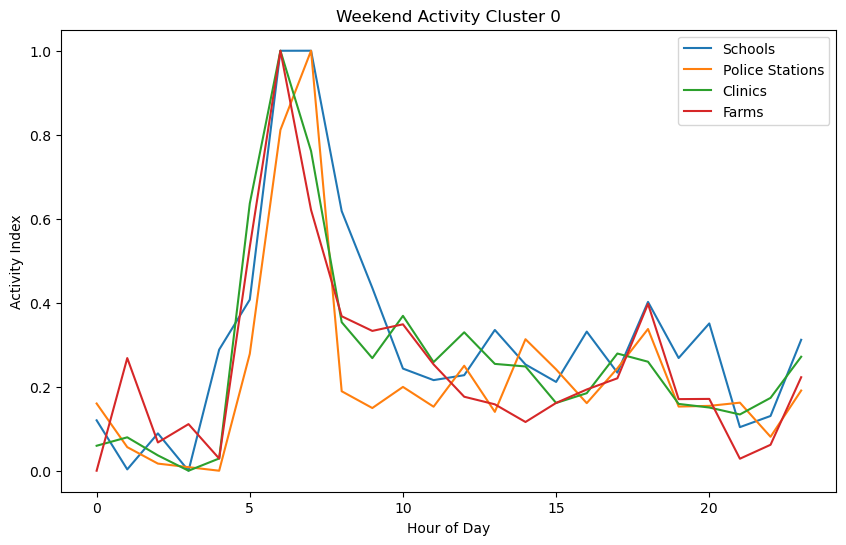

In [371]:
# Plotting weekday schools, police, clinics and farms
plt. figure(figsize=(10, 6)) 
plt.plot(cluster_0_mobility['nov']['cluster_0_schools_hourly_weekend_ai'], label='Schools')
plt.plot(cluster_0_mobility['nov']['cluster_0_police_hourly_weekend_ai'], label='Police Stations')
plt.plot(cluster_0_mobility['nov']['cluster_0_clinics_hourly_weekend_ai'], label='Clinics')
plt.plot(cluster_0_mobility['nov']['cluster_0_farms_hourly_weekend_ai'], label='Farms')
plt.plot
plt.xlabel('Hour of Day')
plt.ylabel('Activity Index')
plt.legend()
plt.title('Weekend Activity Cluster 0')
plt.show()